In [2]:
import os
import re
from time import time

import lda
import nltk
import numpy as np
from datetime import datetime, timedelta
from nltk.tokenize import word_tokenize
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
MONGO_URL = 'mongodb://um.media.mit.edu:27017/super-glue'
db = MongoClient(MONGO_URL).get_default_database()

In [4]:
nlp_data = db['nlp_data'].find_one()
stopwords = nlp_data["stopwords"]
vocab = nlp_data["vocab_non_stemmed"]
vocab_dict = nlp_data["vocab_non_stemmed_dict"]

In [5]:
DAY = 86400000
HOUR = 3600000

def millis():
    return int(round(time() * 1000))
def millis_since(num_days='2'):
    days = int(os.environ.get('TIME_FRAME_DAYS', num_days))
    return millis() - days*DAY
def millis_since_hours(hours):
    return millis()-HOUR*hours

def get_vectors(media):
    segs = media["story_segments"]
    media_url = "media_url_no_comm"
    if not media["module_reports"]["commercial_skip_module"]["removed_commercials"]:
        media_url = "media_url"
    segs_vectors = []
    file_name = lambda x:''.join(x.split('.')[4:])
    for i in range (len(segs)):
        start = segs[i]["start"]
        end = segs[i]["end"]
        thumb = "/static/images/blank.jpg"
        if "thumbnail_image" in segs[i]:
            thumb = segs[i]["thumbnail_image"]
        url = "%s#t=%.2f,%.2f"%(media[media_url],start/1000.0,end/1000.0)
        air_date = media["date_added"]
        length = float(end)-float(start)
        if "word_count" in segs[i]:
            vector = segs[i]["word_count"]
            if len(vector.keys())>3 and length>4000:
                segs_vectors.append({
                    "start":start,
                    "end":end,
                    "url":url,
                    "channel":media["channel"],
                    "length":length,
                    "date":air_date,
                    "thumbnail":thumb,
                    "media_id": str(media["_id"]),
                    "segment_index": i,
                    "vector":vector})
    return segs_vectors

def get_all_segments():
    all_media_has_segments = db['media'].find(
        {"date_added": {"$gt": millis_since('1')},
         "story_segments":{"$exists": True},"is_news":{"$eq": True}})
    num_of_videos = all_media_has_segments.count()
    print "%d videos"%num_of_videos
    all_segments = []
    for media in all_media_has_segments:
        segs = get_vectors(media)
        all_segments.extend(segs)
    print "%d total segments"%len(all_segments)
    return all_segments

def get_tf_matrix(all_segments):
    vectors = dok_matrix((len(all_segments), len(vocab)), dtype=np.int32)
    for i, seg in enumerate(all_segments):
        vec = seg["vector"]
        for ind in vec.keys():
            vectors[i, int(ind)] = int(vec[ind])
        seg.pop("vector")
    return vectors

In [6]:
all_segments = get_all_segments()
tf = get_tf_matrix(all_segments)
transformer = TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
tf_idf = transformer.fit_transform(tf)

117 videos
598 total segments


In [7]:
words_sizes_tf = tf.sum(axis=0)
words_sizes_tfidf = tf_idf.sum(axis=0)

n_topics = len(all_segments)/9

In [8]:
def get_lables(transformed_mat):
    dim = (1,transformed_mat.shape[0])
    aa = np.zeros(dim)
    for i, doc in enumerate(transformed_mat):
        aa[0, i] = doc.argmax()
    return aa

def print_top_words(topic_word, n_top_words, lables, n_topics=None):
    lables_count = []
    for i in range(len(topic_word)):
        lables_count.append(0)
    for doc in lables[0]:
        lables_count[int(doc)]+=1
 
    sorted_topics = np.argsort(lables_count)[::-1]
    if not n_topics:
        n_topics = len(sorted_topics)
        
    for i in range(n_topics):
        topic_idx = sorted_topics[i]
        topic = topic_word[topic_idx]
        print("Topic #%d: - %d" % (topic_idx, lables_count[topic_idx]))
        print(" ".join([vocab[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [9]:
def labels_arr(topics):
    arr = []
    for doc in topics:
        arr.append(doc.argmax())
    return arr

In [10]:
# run NMF
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5)
nmf_result = nmf.fit_transform(tf_idf)
nmf_labels = get_lables(nmf_result)
print("done in %0.3fs." % (time() - t0))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf_idf, labels_arr(nmf_result)))

done in 8.000s.
Silhouette Coefficient: 0.036


In [11]:
# run LDA
n_iter = 500
alpha = 0.1
eta = 0.01
t0=time()
lda_model_scikit = LatentDirichletAllocation(n_topics=n_topics, max_iter=n_iter,
                            learning_method='batch',
                            doc_topic_prior=alpha,
                            topic_word_prior=eta)
lda_result = lda_model_scikit.fit_transform(tf)
print("done in %0.3fs." % (time() - t0))
lda_labels = get_lables(lda_result)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf, labels_arr(lda_result)))

done in 292.214s.
Silhouette Coefficient: -0.337


In [12]:
# run DBSCAN
from sklearn.cluster import DBSCAN

tfidf_distance = metrics.pairwise.pairwise_distances(tf_idf)
sum_distances = sum(sum(tfidf_distance))
avg_dist = sum_distances/(len(all_segments)*len(all_segments))
t0 = time()
db = DBSCAN(eps=avg_dist*0.91, min_samples=1)
db_result = db.fit_predict(tf_idf)
db_labels = db.labels_

#print db_result

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("done in %0.3fs." % (time() - t0))
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf_idf, db_labels))

done in 0.062s.
Estimated number of clusters: 149
Silhouette Coefficient: 0.004


In [13]:
# run Agglomerative Clustering (HCA)
from sklearn.cluster import AgglomerativeClustering

t0 = time()
ag_model = AgglomerativeClustering(n_clusters=n_topics, compute_full_tree=True)
agc_result = ag_model.fit_predict(tf_idf.toarray())

print("done in %0.3fs." % (time() - t0))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf_idf, ag_model.labels_))

done in 7.227s.
Silhouette Coefficient: 0.073


In [47]:
# run Scipy HCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

t0 = time()
hca_result = linkage(tf_idf.toarray(), 'ward')
hca_labels = fcluster(hca_result, n_topics, criterion='maxclust')
hca_better = fcluster (hca_result, 180, criterion='maxclust')

print("done in %0.3fs." % (time() - t0))
print("Silhouette Coefficient %d topics: %0.3f"
      % (n_topics, metrics.silhouette_score(tf_idf, hca_labels)))
print("Silhouette Coefficient 180 topics: %0.3f"
      % metrics.silhouette_score(tf_idf, hca_better))
    

done in 7.102s.
Silhouette Coefficient 66 topics: 0.073
Silhouette Coefficient 180 topics: 0.112


In [ ]:
i = 2
while i < len(all_segments)-1:
    le = fcluster(hca_result, i, criterion='maxclust')
    print i
    print "Silhouette Coefficient: %0.3f"%metrics.silhouette_score(tf_idf, le)
    i+=15

In [15]:
# run K means
from sklearn.cluster import KMeans
t0 = time()
kmeans = KMeans(n_clusters=n_topics, random_state=0).fit(tf_idf)
kmeans_result = kmeans.labels_

print("done in %0.3fs." % (time() - t0))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf_idf, kmeans_result))

done in 6.957s.
Silhouette Coefficient: 0.042


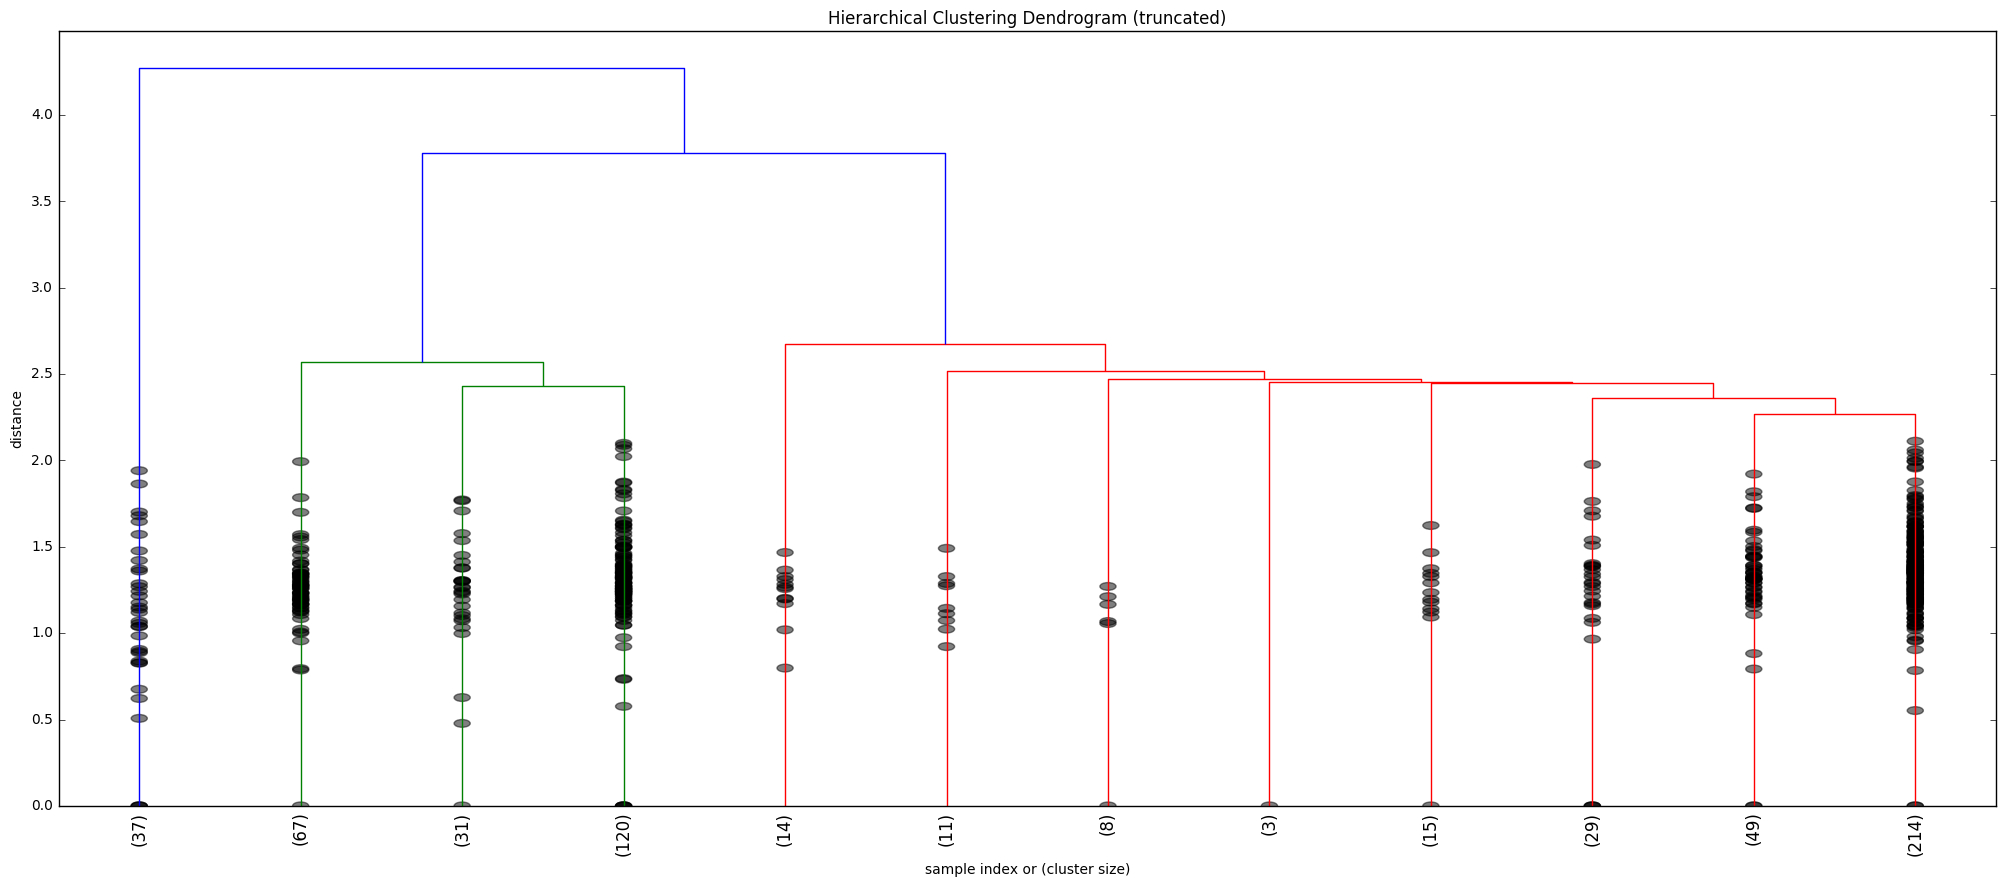

In [27]:

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    hca_result,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [28]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

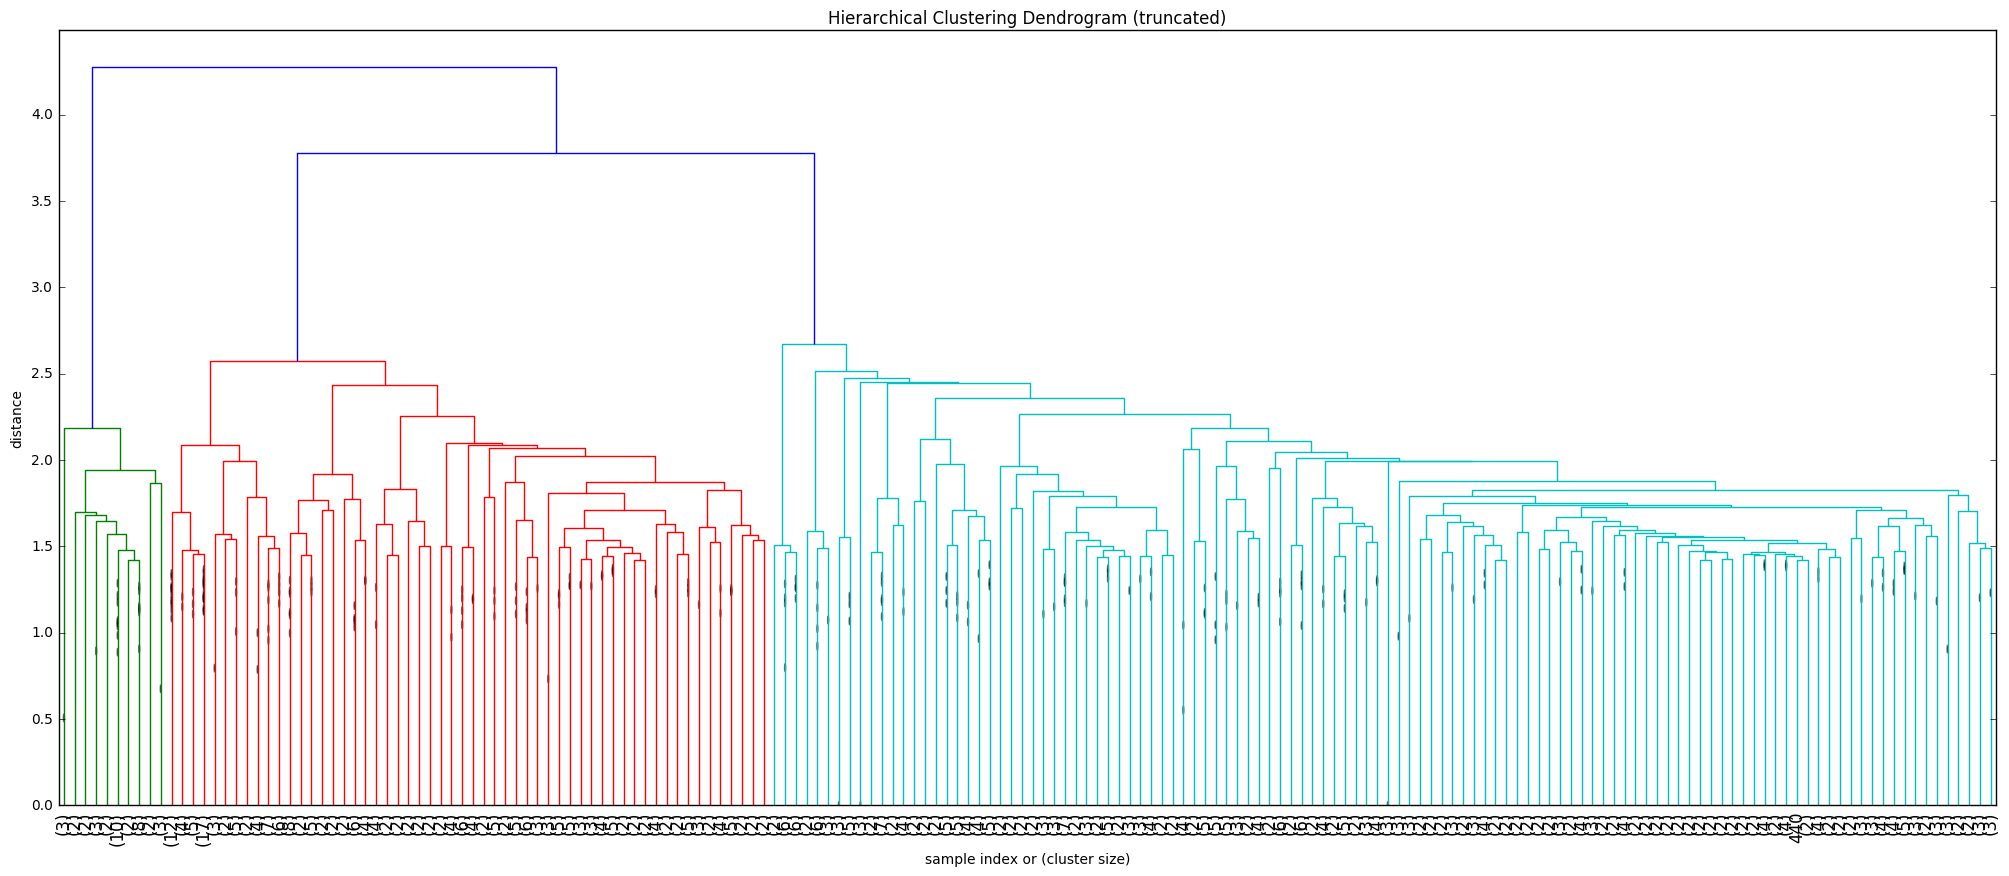

In [48]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    hca_result,
    truncate_mode='lastp',
    p=180,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

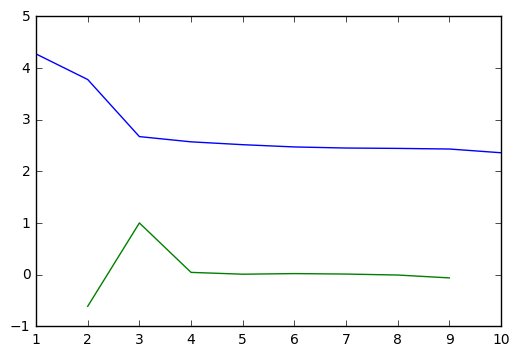

clusters: 3


In [34]:
last = hca_result[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k